___
# Difference-in-Differences

- This method is handy when a true A/B test is not possible to do.
- Allows us to quantify the impact of an intervention, by picking up an adequate (pseudo)control group

In [2]:
from IPython.display import IFrame

# Youtube
IFrame('https://www.youtube.com/embed/IpWQlHapifU', 560, 315)

## Reference
# https://www.mailman.columbia.edu/research/population-health-methods/difference-difference-estimation
# https://towardsdatascience.com/causal-inference-101-difference-in-differences-1fbbb0f55e85

___

## Import Libraries

In [1]:
## remove this, this is for my personal pc setup
import sys; import os; sys.path.append(os.path.expanduser('~/DropBox/my/projects/T/'))

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas   as pd
import operator as op

import numpy             as np
import seaborn           as sns
from datetime import datetime

import pyscope
from pyscope import read_ss

from T import * # want T to be accessible

%load_ext autoreload
%autoreload

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Generate Data

In [4]:
# Test Data

treatment = pd.DataFrame({'user':['a','b','a','c','a','b'] \
                 , 'date': [datetime.strptime(d, '%Y-%m-%d') for d in ['2018-10-16', '2018-10-16', '2018-10-17', '2018-10-17', '2018-10-18', '2018-10-19']]
                 , 'period':['before', 'before', 'before', 'before', 'after','after'] \
                 , 'cohort':['treatment','treatment','treatment','treatment','treatment','treatment'] \
                 , 'kpi':[10,11,12,13,25,35]})


control   =  pd.DataFrame({'user':['k','j','k','t','k','j'] \
                 , 'date': [datetime.strptime(d, '%Y-%m-%d') for d in ['2018-10-16', '2018-10-16', '2018-10-17', '2018-10-17', '2018-10-18', '2018-10-19']]
                 , 'period':['before', 'before', 'before', 'before', 'after','after'] \
                 , 'cohort':['control','control','control','control','control','control'] \
                 , 'kpi':[5,6,7,8,9,10]})

display(treatment, control)

,user,date,period,cohort,kpi
0,a,2018-10-16,before,treatment,10
1,b,2018-10-16,before,treatment,11
2,a,2018-10-17,before,treatment,12
3,c,2018-10-17,before,treatment,13
4,a,2018-10-18,after,treatment,25
5,b,2018-10-19,after,treatment,35


,user,date,period,cohort,kpi
0,k,2018-10-16,before,control,5
1,j,2018-10-16,before,control,6
2,k,2018-10-17,before,control,7
3,t,2018-10-17,before,control,8
4,k,2018-10-18,after,control,9
5,j,2018-10-19,after,control,10


In [5]:
treatment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
user      6 non-null object
date      6 non-null datetime64[ns]
period    6 non-null object
cohort    6 non-null object
kpi       6 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 320.0+ bytes


## DiD requirement

Composition of intervention and comparison groups needs to be stable for repeated cross-sectional design.

(from https://www.mailman.columbia.edu/research/population-health-methods/difference-difference-estimation)

i.e. remove users that are not present in both periods ("before" and "after")

In [6]:
def _by_user(df):
    names = {
          'inBothPeriods' : T(df)['period'].nunique() > 1
    }
    return pd.Series(names, index=names.keys())

treatment = pd.merge(treatment, T(treatment).groupby('user').apply(_by_user).reset_index())
control   = pd.merge(control,   T(control).groupby('user').apply(_by_user).reset_index())

In [7]:
# filter for both periods
treatment = T(treatment).where("inBothPeriods", True)
control   = T(control).where("inBothPeriods", True)

display(treatment, control)

,user,date,period,cohort,kpi,inBothPeriods
0,a,2018-10-16,before,treatment,10,True
1,a,2018-10-17,before,treatment,12,True
2,a,2018-10-18,after,treatment,25,True
3,b,2018-10-16,before,treatment,11,True
4,b,2018-10-19,after,treatment,35,True


,user,date,period,cohort,kpi,inBothPeriods
0,k,2018-10-16,before,control,5,True
1,k,2018-10-17,before,control,7,True
2,k,2018-10-18,after,control,9,True
3,j,2018-10-16,before,control,6,True
4,j,2018-10-19,after,control,10,True


## Plot Treatment and Control KPI

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


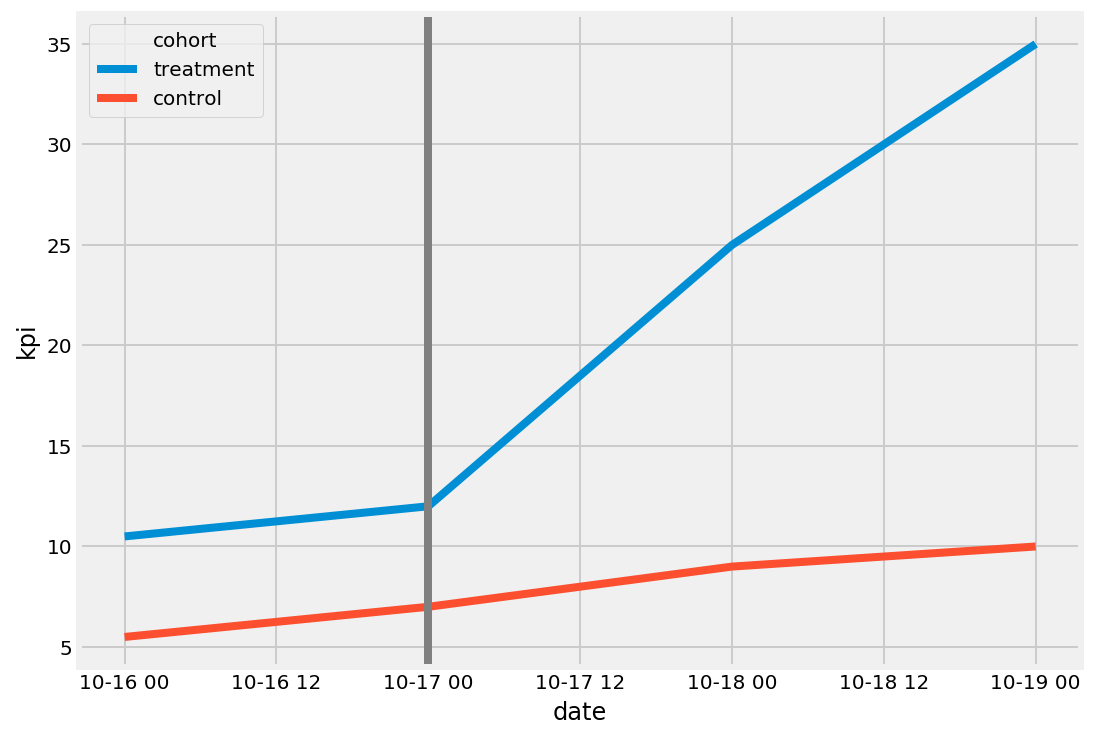

In [8]:
## Group by date, median of KPI, per cohort
def day_agg(df):
    names = {
        'kpi':    np.median(df['kpi']),
        'cohort': np.max(df['cohort'])
    }
    return pd.Series(names, index=['kpi', 'cohort'])

treat  = treatment.groupby('date').apply(day_agg).reset_index()
ctrl   = control.groupby('date').apply(day_agg).reset_index()

plt.figure(figsize=(8, 6))
sns.lineplot(x="date", y="kpi", hue="cohort", data=pd.concat([treat, ctrl]))
plt.axvline(np.max(T(treatment).where("period", "before").column("date")), 0,1,linewidth=4, color='grey' )


The vertical grey line marks the start of the intervention, see that:
- Both treatment and control before the intervention are perfectly parallel, this is a requirement in applying this method, means these fair groups (control and treatment) to compare here.
- Note that after the intervention the trends change, so next we quantify the impact of the intervention


## DID Calculation


- Do user level aggregations of the metric we are focusing on, kpi
- Separate before and after period and calculate metric for each user for A, B, C, D

In [9]:
# 
def user_agg(df):
    names = {
        'kpi': np.mean(df['kpi'])
    }
    return pd.Series(names, index=['kpi'])


_treat_pre  = treatment.loc[treatment['period'] == 'before'].groupby('user').apply(user_agg).reset_index()
_treat_post = treatment.loc[treatment['period'] == 'after'].groupby('user').apply(user_agg).reset_index()

_ctrl_pre  = control.loc[control['period'] == 'before'].groupby('user').apply(user_agg).reset_index()
_ctrl_post = control.loc[control['period'] == 'after'].groupby('user').apply(user_agg).reset_index()

display(_treat_pre, _treat_post, _ctrl_post, _ctrl_pre)

,user,kpi
0,a,11.0
1,b,11.0


,user,kpi
0,a,25.0
1,b,35.0


,user,kpi
0,j,10.0
1,k,9.0


,user,kpi
0,j,6.0
1,k,6.0


#### Bootstrap sampling by user


We don't calculate the DiD directly, we instead follow the probabilistic approach and calculate bootstrap samples, to better simulate/predict collecting multiple samples from the population.

**nb:** In this toy example there's to little data for this method to be statistical significant sense, but this codes serves as example that can be applied to other data

In [10]:
## Bootstrap sampling
### draw_bs_reps: Generates bootstrap replicates out of `data` using `func`, collects `size` samples
### samples w/ replacement

treat_pre  = stats.draw_bs_reps(_treat_pre[['kpi']].values.flatten(),  func=np.mean, size=10000)
treat_post = stats.draw_bs_reps(_treat_post[['kpi']].values.flatten(), func=np.mean, size=10000)
ctrl_pre   = stats.draw_bs_reps(_ctrl_pre[['kpi']].values.flatten(),   func=np.mean, size=10000)
ctrl_post  = stats.draw_bs_reps(_ctrl_post[['kpi']].values.flatten(),  func=np.mean, size=10000)

In [11]:
# DID
DiD = (treat_post - treat_pre) - (ctrl_post - ctrl_pre)

Shows the probabilistic* distribution of the impact of intervention.

*probabilistic = functions as collecting several samples from population, and for each we calculate the impact of intervention. Doing this for enought samples, we get a quite accurate measure of impact. Including lets us calculate the confidence intervals for it.

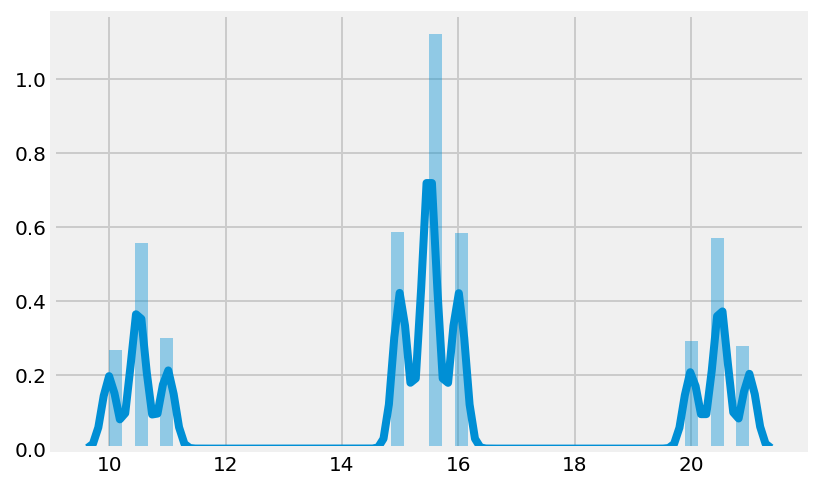

In [12]:
sns.distplot(DiD)

## Summary of Intervention

In [13]:

print("""
Treatment Before:  KPI mean = {0:.3f}
                   NUsers   = {1:.0f}

Treatment After :  KPI mean = {2:.3f}
                   NUsers   = {3:.0f}


Control Before:    KPI mean = {4:.3f}
                   NUsers   = {5:.0f}

Control After :    KPI mean = {6:.3f}
                   NUsers   = {7:.0f}

DID: 95% Confidence for Treatment KPI uplift after the intervention
conf. int. = [{8:.1f}, {9:.1f}] 

""".format(  np.mean(_treat_pre[['kpi']])[0] \
           , treatment.loc[treatment['period'] == 'before']['user'].nunique()  \
           , np.mean(_treat_post[['kpi']])[0] \
           , treatment.loc[treatment['period'] == 'after']['user'].nunique()  \
           , np.mean(_ctrl_pre[['kpi']])[0] \
           , control.loc[control['period'] == 'before']['user'].nunique()  \
           , np.mean(_ctrl_post[['kpi']])[0] \
           , control.loc[control['period'] == 'after']['user'].nunique()  \
           , np.percentile(DiD, [2.5, 97.5])[0] \
           , np.percentile(DiD, [2.5, 97.5])[1] \
          ))



Treatment Before:  KPI mean = 11.000
                   NUsers   = 2

Treatment After :  KPI mean = 30.000
                   NUsers   = 2


Control Before:    KPI mean = 6.000
                   NUsers   = 2

Control After :    KPI mean = 9.500
                   NUsers   = 2

DID: 95% Confidence for Treatment KPI uplift after the intervention
conf. int. = [10.0, 21.0] 


